# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Business Understanding

The dataset seems to belong to some digital music streaming Platforms. Whenever a user interacts with the music streaming service the logs get generated like timestamp and the activity page(i.e logOut, like, logIn etc). There are basically types of user 1. free -tier and 2. subscription-based. so based on the activity of the user we need to figure out which user is likely to churn out. So, some kind of discounts can be rolled out to those specific users.

# Data Understanding

the datat is contained in a file `mini_sparkify_event_data.json` 
Data description :
* artist: string name of artist
* auth : String authencation levels
* firstName: string first name of user
* gender: string Gender of user
* itemInSession: long log count in the session
* lastName: string last name of the user
* length: double length of the song
* level: string type of subscription
* location: string location of user
* method: string tupe of request
* page: string type of interaction
* registration: long registration timestamp
* sessionId: long session id of the user
* song: string name of song
* status: long http status code
* ts: long timestamp
* userAgent: string agent used by user for straeming service
* userId: string inique identifier of  the user


In [130]:
# import libraries
from pyspark.sql import SparkSession,Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, when, isnull, collect_list,dayofmonth
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as f

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

import re
from functools import reduce

import pandas as pd
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [3]:
# create a Spark session
sc =  SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Read dataset
filename = 'mini_sparkify_event_data.json'
df = sc.read.json(filename)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
def show_df(df):
    """
        ARGS:
            - spark Dataframe
        RETURNS:
            - Prints dataframe
    """
    return df.toPandas().head()
show_df(df)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30


In [6]:
def df_dimentions(df):
    """
        Prints number of Rows and Columns
        ARGS:
            - Dataframe
    """
    print(f"row count: {df.count()}, column count: {len(df.columns)}")
df_dimentions(df)

row count: 286500, column count: 18


In [8]:
## remove special characters from column
def remove_special_chars(df):
    """
        removes special characters from data
        ARGS:
            - Dataframe
        RETURNS:
            - clear Dataframe
    """
    for field in df.schema.fields:
        if field.dataType == StringType():
            df = df.withColumn(field.name,regexp_replace(field.name,'[^a-zA-Z0-9\,\-]',''))
    
    return df
#df = remove_special_chars(df)
show_df(df)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,MarthaTilston,LoggedIn,Colin,M,50,Freeman,277.89016,paid,"Bakersfield,CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla50WindowsNT61WOW64rv310Gecko20100101Firefox310,30
1,FiveIronFrenzy,LoggedIn,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton,MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML,likeGeckoChrome3702062103Safari53736",9
2,AdamLambert,LoggedIn,Colin,M,51,Freeman,282.82730,paid,"Bakersfield,CA",PUT,NextSong,1.538173e+12,29,TimeForMiracles,200,1538352394000,Mozilla50WindowsNT61WOW64rv310Gecko20100101Firefox310,30
3,Enigma,LoggedIn,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton,MA-NH",PUT,NextSong,1.538332e+12,8,KnockingOnForbiddenDoors,200,1538352416000,"Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML,likeGeckoChrome3702062103Safari53736",9
4,DaftPunk,LoggedIn,Colin,M,52,Freeman,223.60771,paid,"Bakersfield,CA",PUT,NextSong,1.538173e+12,29,HarderBetterFasterStronger,200,1538352676000,Mozilla50WindowsNT61WOW64rv310Gecko20100101Firefox310,30


In [7]:
def convert_unixtimestamp(df,ts_col):
    """
        converts unix timestamp to date time
        ARGS:
            - df: Dataframe with Unixtimestamp
            - ts: unixtimestamp column name
        RETURNS:
            - dataframe with new datetime column
    """
   
    df = df.withColumn("dateTime",from_unixtime(col(ts_col).cast(LongType())/1000).cast(TimestampType()))
    df = df.withColumn("month",month(col('dateTime')))
    df = df.withColumn("dayOfMonth",dayofmonth(col('dateTime')))
    df = df.withColumn("hour",hour(col('dateTime')))
    df = df.withColumn("date",from_unixtime(col(ts_col)/1000).cast(DateType()))
    df = df.withColumn("location",split(col('location'),',').getItem(1))
    df = df.filter(col('userId').isNotNull())
    return df


In [8]:
# create time series columns
df = convert_unixtimestamp(df,'ts')

In [9]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- dateTime: timestamp (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayOfMonth: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- date: date (nullable = true)



In [10]:
df.filter(col('userId').isNull()).count()

0

In [11]:
# Dropping the missing User's ID rows
df = df.filter(df.userId != '')
# Check
df.filter(df.userId == '').count()

0

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
def bar_plot(df,col1,col2=None,hue=None,labels=None):
    """
        plots using the data 
        ARGS:
            - df: Pandas Dataframe
    """
    plt.figure(figsize=(15,5))
    plot = sns.barplot(data=df,x=col1,y=col2,hue=hue)
    plot.set_xticklabels(labels)
    plt.show()
    

In [13]:
def distinct_attributes(df,col_name):
    """
        Prints all the distinct attributes/values of a single column
        ARGS:
            - df: Dataframe
            - col_name: Name of the column for distinct attributes
        
    """
    print(df.select(col_name).distinct().collect())

In [14]:
def categorical_columns(df):
    """
        prints distinct values of categorical columns
        ARGS:
            - df: Dataframe
    """
    for field in df.schema.fields:
        if ((field.dataType == StringType()) and (field.name not in ['userId','lastName','userAgent','firstName','artist','song'] )):
            print(field.name)
            distinct_attributes(df,field.name)
            print("*"*50)
categorical_columns(df)

auth
[Row(auth='Cancelled'), Row(auth='Logged In')]
**************************************************
gender
[Row(gender='F'), Row(gender='M')]
**************************************************
level
[Row(level='free'), Row(level='paid')]
**************************************************
location
[Row(location=' NE-IA'), Row(location=' PA-NJ'), Row(location=' WA'), Row(location=' DC-VA-MD-WV'), Row(location=' AL'), Row(location=' MI'), Row(location=' MN-WI'), Row(location=' IL-IN-WI'), Row(location=' MD-WV'), Row(location=' NH'), Row(location=' AK'), Row(location=' AR'), Row(location=' AZ'), Row(location=' MA-NH'), Row(location=' WV'), Row(location=' TN-MS-AR'), Row(location=' MO-IL'), Row(location=' TN'), Row(location=' NY'), Row(location=' MD'), Row(location=' OH'), Row(location=' FL'), Row(location=' IL'), Row(location=' IL-MO'), Row(location=' LA'), Row(location=' CA'), Row(location=' NY-NJ-PA'), Row(location=' UT'), Row(location=' TX'), Row(location=' SC'), Row(location=' MO-KS

In [15]:
#filter pages of type CancellationConfirmation
df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(10)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
+------+
only showing top 10 rows



In [16]:
def create_label(df):
    """
        Create label columns containing 1,0 for cancellation page and auth is cancled
        ARGS:
            - df: Dataframe 
        RETURNS:
            - Dataframe with labeled columns
    """
    
    flag_cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    # apply to the dataframe
    df = df.withColumn("label", flag_cancelation_event("page"))
    #Define window bounds
    windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    # Applying the window
    df = df.withColumn("label", sum("label").over(windowval))
    return df
# Create Label as churn Column
df = create_label(df)
show_df(df)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,dateTime,month,dayOfMonth,hour,date,label
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,CT,PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 18:28:54,10,8,18,2018-10-08,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,CT,PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 18:32:16,10,8,18,2018-10-08,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,CT,PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 18:35:32,10,8,18,2018-10-08,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,CT,PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 18:35:33,10,8,18,2018-10-08,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,CT,PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 18:39:55,10,8,18,2018-10-08,0


In [17]:
# Number of users in Dataset
df.select('userId').dropDuplicates().count()

225

In [18]:
# create dataframe for plotting count of different labels of all the users
label_df = df.dropDuplicates(['userId']).groupby(['label']).count()
label_df = label_df.toPandas()

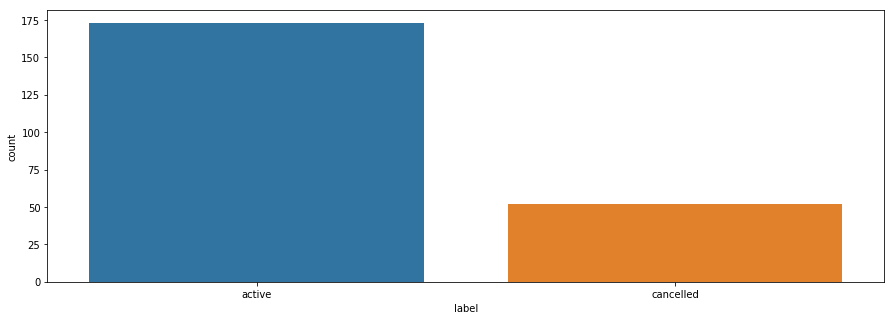

In [19]:
# the data set is highly imbalanced
bar_plot(label_df,'label','count',labels=['active','cancelled'])

In [93]:
# types of user churn by gender
gender_df = df.dropDuplicates(['userId', 'gender']).groupby(['label', 'gender']).count()
gender_df = gender_df.toPandas()

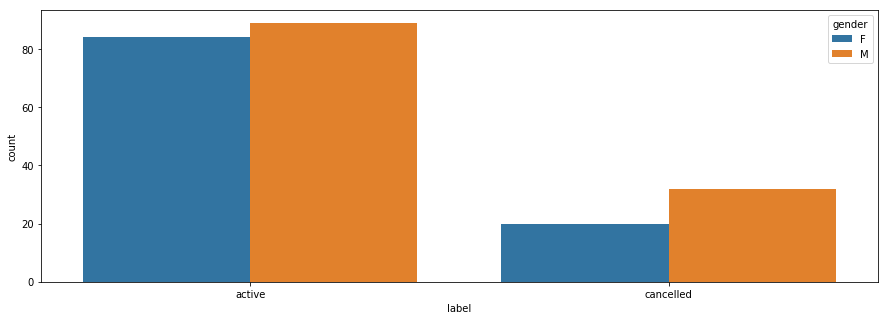

In [94]:
bar_plot(gender_df,'label','count','gender',labels=['active','cancelled'])

In [95]:
# User status by paid level
paid_df = df.dropDuplicates(['userId', 'level']).groupby(['label', 'level']).count()
paid_df = paid_df.toPandas()

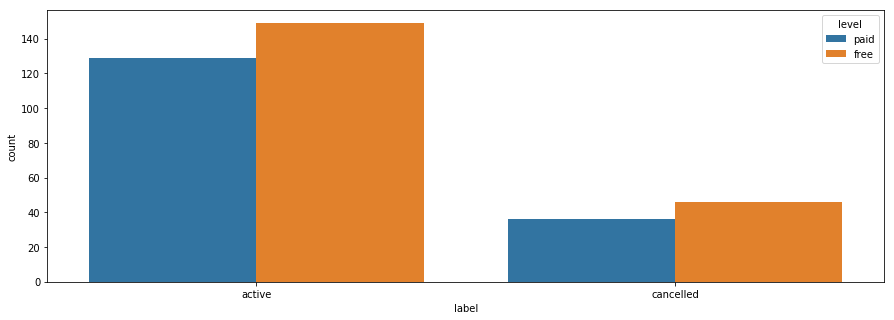

In [96]:
bar_plot(paid_df,'label','count','level',labels=['active','cancelled'])

* free users are more likely to cancel subscription 

In [97]:
# count of user location wise 
location_df = df.dropDuplicates().groupBy(['location']).agg(count('location').alias('count'))
location_df = location_df.toPandas()
location_df.head()

,location,count
0,NE-IA,187
1,PA-NJ,815
2,WA,3772
3,DC-VA-MD-WV,3090
4,AL,2857


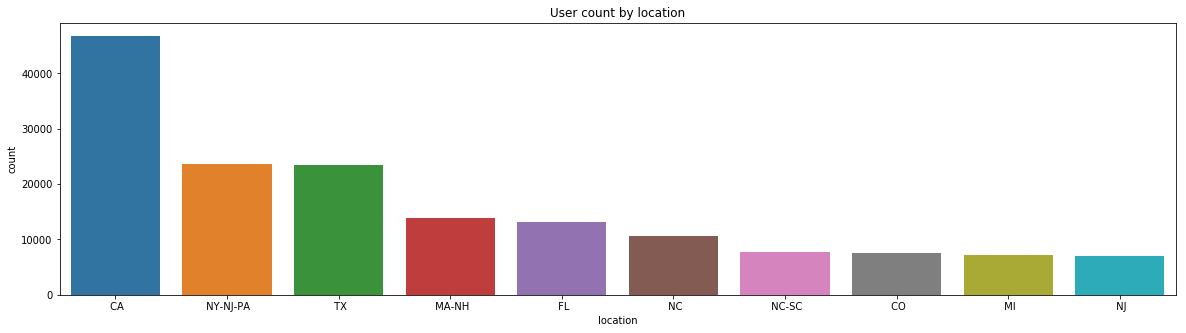

In [92]:
#plot to 10 location
plt.figure(figsize=(20,5))
sns.barplot(data=location_df.sort_values(by='count',ascending=False).head(10),x='location',y='count')
plt.title('User count by location')
plt.show()

* CA , NY, TX, MA, FL, NC has top 5 locations based on user

In [93]:
active_df = df.drop_duplicates().groupby(['auth']).agg(count('auth').alias('count'))
active_df = active_df.toPandas()

count based on type of auth


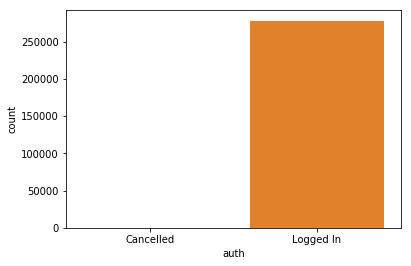

In [94]:
sns.barplot(x='auth',y='count',data=active_df)
print('count based on type of auth')

* most of the data belonged to LoggedIn user

In [95]:
# user by  page
user_page_df = df.groupBy(['page']).agg(count('userId').alias('userCount')).drop('NextSong')
user_page_df = user_page_df.toPandas().sort_values(by='userCount',ascending=False) 
user_page_df                       

,page,userCount
13,NextSong,228108
14,Thumbs Up,12551
3,Home,10082
11,Add to Playlist,6526
12,Add Friend,4277
5,Roll Advert,3933
6,Logout,3226
2,Thumbs Down,2546
4,Downgrade,2055
10,Settings,1514


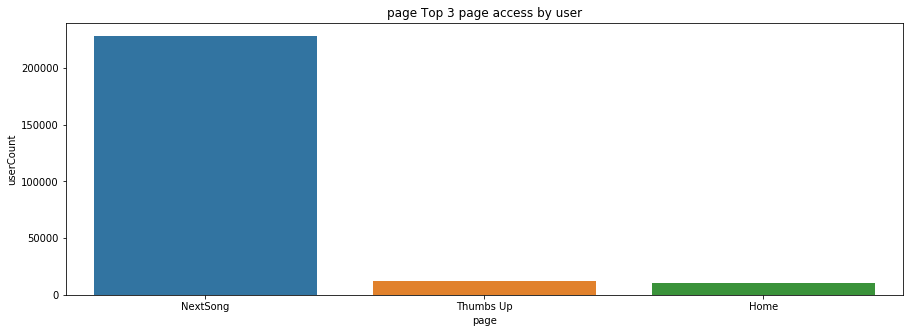

In [96]:
plt.figure(figsize=(15,5))
sns.barplot(x='page',y='userCount',data=user_page_df.head(3))
plt.title('page Top 3 page access by user')
plt.show()

* NextSong Page was the most used page which is quite obvious in music streaming app

In [32]:
def count_missings(spark_df,sort=True):
    """
        Counts number of nulls and nans in each column
        ARGS:
            - spark_df: RDD dataframe 
    """
    df = spark_df.select([f.count(f.when(f.isnan(c) | f.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'missing_value_count'}).T.sort_values("missing_value_count",ascending=False)

    return df

In [33]:
count_missings(df)

,missing_value_count
length,50046
itemInSession,0
registration,0
sessionId,0
status,0
ts,0
month,0
dayOfMonth,0
hour,0
label,0


In [57]:
def plot_spark_df(df,col_name):
    """
        Plots histogram for from spark dataframe
        ARGS:
            - df: Spark dataframe
    """
    pd_df = df.toPandas()
    plt.figure(figsize=(15,5))
    sns.barplot(x=col_name,data=pd_df)

In [22]:
# udf to get weekday
# reference: https://stackoverflow.com/questions/38928919/how-to-get-the-weekday-from-day-of-month-using-pyspark

funcWeekDay =  udf(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%w'))     

df = df.withColumn('shortdate',col('dateTime').substr(1, 10))\
     .withColumn('weekDay', funcWeekDay(col('shortdate')))\
     .drop('shortdate')
show_df(df)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,dateTime,month,dayOfMonth,hour,date,label,weekDay
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,CT,PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 18:28:54,10,8,18,2018-10-08,0,1
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,CT,PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 18:32:16,10,8,18,2018-10-08,0,1
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,CT,PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 18:35:32,10,8,18,2018-10-08,0,1
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,CT,PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 18:35:33,10,8,18,2018-10-08,0,1
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,CT,PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",100010,2018-10-08 18:39:55,10,8,18,2018-10-08,0,1


In [23]:
# lets see month wise analysis of churned user
month1_user_df = df.filter(col('label') == 1).groupby(col('month')).agg(count(col('userId')).alias('churnedUserCount'))
month2_user_df = df.filter(col('label') == 0).groupby(col('month')).agg(count(col('userId')).alias('unChurnedUserCount'))
month_churn_df = month1_user_df.join(month2_user_df,on='month',how='full').fillna(0).toPandas().melt(id_vars='month')

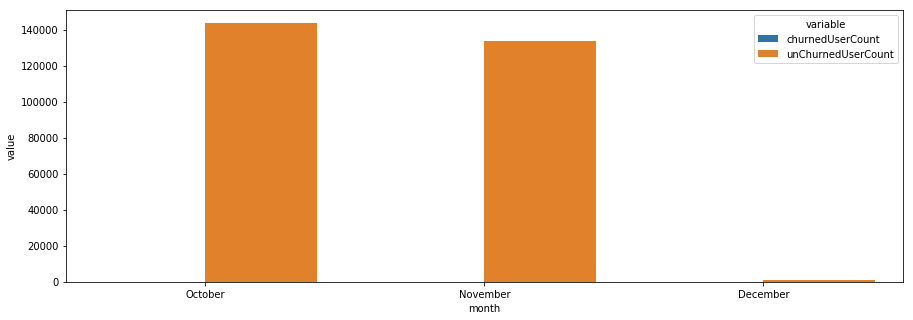

In [99]:
seab = bar_plot(month_churn_df,col2='value',col1='month',hue='variable',labels=['October','November','December'])

* churn count is high in October but reduced in November

In [24]:
weekday_gender_df = df.groupby('weekDay','gender').agg(count('userId').alias('userCount'))
weekday_gender_df = weekday_gender_df.toPandas()
weekday_gender_df

,weekDay,gender,userCount
0,0,M,9411
1,4,F,23811
2,1,M,17570
3,3,M,20360
4,6,F,18303
5,2,F,25374
6,0,F,13091
7,2,M,20553
8,6,M,14651
9,1,F,18530


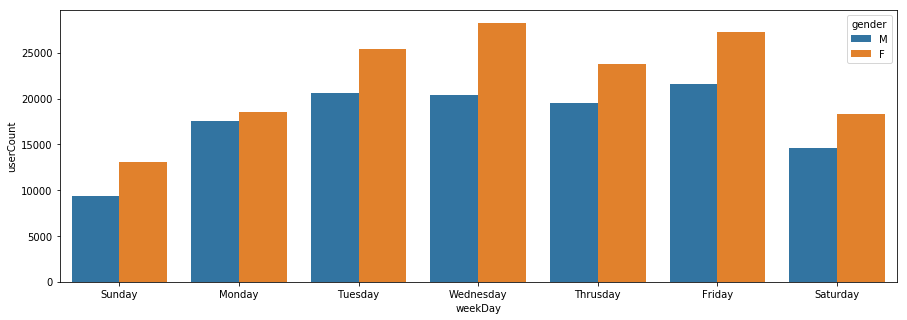

                                        daywise churn count of user comparison male vs Female


In [101]:
labels = ['Sunday','Monday','Tuesday','Wednesday','Thrusday','Friday','Saturday']
bar_plot(weekday_gender_df,col1='weekDay',col2='userCount',hue='gender',labels=labels)
print(" "*40+'daywise churn count of user comparison male vs Female')

* churn rate is low on Sunday and Saturday, Females have high Churn rate

In [102]:
day_and_gender_df = df.groupby('gender','dayOfMonth').agg(count('userId').alias('userCount'))
day_and_gender_df = day_and_gender_df.toPandas()

TypeError: 'NoneType' object is not iterable

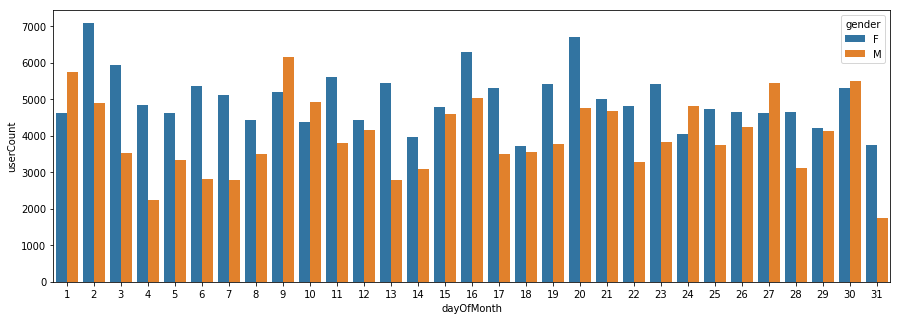

In [103]:
bar_plot(day_and_gender_df,col1='dayOfMonth',hue='gender',col2='userCount')

* Churn count is high in the Females for starting days of month. 1st of the month the churn count is high in male. since the dataset contains few months of data concrete results can be drawn. 

In [158]:
gender_df.head()

,label,gender,count
0,0,F,84
1,1,M,32
2,1,F,20
3,0,M,89


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [20]:
def convert_cat(df,col_name,val):
    """
        encodes categorical column 
        ARGS:
            df: Spark Dataframe
            col: Column to be encoded
            val: Dictonary for encoding values
        RETURNS:
            - SparkDataframe Encoded variable
    """
    temp_df = df.select('userId',col_name).dropDuplicates().replace(val,subset=col_name)
    temp_df = temp_df.withColumn(col_name,temp_df[col_name].cast(IntegerType()))
    print(temp_df.show(3))
    return temp_df
gender_encoded_df = convert_cat(df,'gender',{'M':'1','F':'0'})
show_df(gender_encoded_df)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
+------+------+
only showing top 3 rows

None


,userId,gender
0,44,0
1,46,0
2,41,0
3,72,0
4,300023,0


In [21]:
# lets investigate the type of os used by user to access the Song streaming platform
# Number of unique platforms
dfp = df.toPandas()

In [22]:
agents = [x.strip() for x  in dfp.userAgent.unique()] 
[agents[x] for x in [0, 2, 4, 10]]

['"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"',
 '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
 '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
 '"Mozilla/5.0 (iPad; CPU OS 7_1_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D201 Safari/9537.53"']

In [23]:
# regex to extract platform name
import re
ex = '\(([^\)]*)\)'

# All OSs
sorted(list(set([re.findall(
    ex, x)[0].split(';')[0].capitalize(
) for x  in agents])))

['Compatible',
 'Ipad',
 'Iphone',
 'Macintosh',
 'Windows nt 5.1',
 'Windows nt 6.0',
 'Windows nt 6.1',
 'Windows nt 6.2',
 'Windows nt 6.3',
 'X11']

In [24]:
# Create mappers for the os
mapper_general = {'Compatible': 'Windows',  'Ipad': 'Mac',  'Iphone': 'Mac',  
          'Macintosh': 'Mac',  'Windows nt 5.1': 'Windows',  
          'Windows nt 6.0': 'Windows',  'Windows nt 6.1': 'Windows',  
          'Windows nt 6.2': 'Windows',  'Windows nt 6.3': 'Windows',  
          'X11': 'Linux'}
mapper_specific = {'Compatible': 'Windows 7',  'Ipad': 'iPad',  'Iphone': 'iPhone',  
          'Macintosh': 'MacOS',  'Windows nt 5.1': 'Windows XP',  
          'Windows nt 6.0': 'Windows Vista',  'Windows nt 6.1': 'Windows 7',  
          'Windows nt 6.2': 'Windows 8.0',  'Windows nt 6.3': 'Windows 8.1',  
          'X11': 'Linux'}
print(sorted(list(set([mapper_general[re.findall(ex, x)[0].split(';')[0].capitalize()] for x  in agents]))),
sorted(list(set([mapper_specific[re.findall(ex, x)[0].split(';')[0].capitalize()] for x  in agents]))))

['Linux', 'Mac', 'Windows'] ['Linux', 'MacOS', 'Windows 7', 'Windows 8.0', 'Windows 8.1', 'Windows Vista', 'Windows XP', 'iPad', 'iPhone']


In [25]:
os_general = udf(lambda x: mapper_general[re.findall(ex, x)[0].split(';')[0].capitalize()])
df = df.withColumn("os_general", os_general(df.userAgent))

os_specific = udf(lambda x: mapper_specific[re.findall(ex, x)[0].split(';')[0].capitalize()])
df = df.withColumn("os_specific", os_specific(df.userAgent))

In [26]:
os_titles =  df.select('os_specific').distinct().rdd.flatMap(lambda x: x).collect()
os_expr = [f.when(f.col('os_specific') == osdt, 1).otherwise(0).alias("OS_" + osdt) for osdt in os_titles]
os_df = df.select('userId', *os_expr)
os_df.show(10)

+------+-------+---------+--------------+--------+----------------+--------------+--------+-------------+------------+
|userId|OS_iPad|OS_iPhone|OS_Windows 8.1|OS_Linux|OS_Windows Vista|OS_Windows 8.0|OS_MacOS|OS_Windows XP|OS_Windows 7|
+------+-------+---------+--------------+--------+----------------+--------------+--------+-------------+------------+
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       

In [27]:
os_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- OS_iPad: integer (nullable = false)
 |-- OS_iPhone: integer (nullable = false)
 |-- OS_Windows 8.1: integer (nullable = false)
 |-- OS_Linux: integer (nullable = false)
 |-- OS_Windows Vista: integer (nullable = false)
 |-- OS_Windows 8.0: integer (nullable = false)
 |-- OS_MacOS: integer (nullable = false)
 |-- OS_Windows XP: integer (nullable = false)
 |-- OS_Windows 7: integer (nullable = false)



In [28]:
# Encoding the level column
level_df = convert_cat(df,'level',{'paid':'1','free':'0'})
show_df(level_df)

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
+------+-----+
only showing top 3 rows

None


,userId,level
0,100021,0
1,200021,0
2,200001,0
3,6,0
4,300022,1


In [29]:
# calulate the duration a user spends on Music streaming App
def calculate_active_duration(df):
    """
        Calculates number of days a user is active since the day he registerd
        ARGS:
            - dataframe
        REURNS:
            - Dataframe with new colum activeDuration
    """
    df = df.withColumn('regDatetime',from_unixtime(col('registration')/1000).cast(DateType()))
    user_duration_df = df.groupBy('UserId','regDatetime').agg(max('date').alias('lastInterationDate')) 
    diff  = (f.unix_timestamp('lastInterationDate')-f.unix_timestamp('regDatetime'))
    duration_df = user_duration_df.withColumn('activeDuration',diff/86400)
    
    df = df.join(duration_df,on='UserId')
    return df  

In [30]:
df = calculate_active_duration(df)
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- dateTime: timestamp (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayOfMonth: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- label: long (nullable = true)
 |-- os_general: string (nullable = true)
 |-- os_specific: string (nullable

In [31]:
def user_session_sum():
    """
        Create a column containing the sum of ItemInSession column
        RETURNS:
            - Dataframe containing column sumItemInSession 
    """
    item_sum_df = df.groupby('userId').agg(sum(col('itemInSession')).alias('sumItemInSession'))
    df =  df.join(item_sum_df,on='userId')
    return df

In [32]:
def user_stats(df):
    """
        Calculate Song length per user per session 
        ARGS:
            - df: SparkDataframe
        RETURNS:
            - Spark Dataframe with meanHours and stdevHours
    """
    song_length = df.filter(df.page=='NextSong').select('userId', 'sessionId', 'length')
    song_length = song_length.withColumn('hours', (song_length.length / 3600))
    song_length = song_length.groupBy('userId', 'sessionId').sum('hours')
    song_length = song_length.groupBy('userId').agg(
                        avg('sum(hours)').alias('meanHours'), 
                        stddev('sum(hours)').alias('stdevHours')).na.fill(0)
    
    return song_length

In [33]:
def songs_per_session(df):
    """
        number of changing songs
        ARGS:
            - df: Sparkdataframe
        RETURNS:
            - pandas dataframe with columns meanSongs, stdevSongs
    """
    song_user_df = df.filter(df.page == 'NextSong').groupBy(
                        'userId', 'sessionId').count()
    song_user_df = song_user_df.groupBy('userId').agg(
                        avg('count').alias('meanSongs'), 
                        stddev('count').alias('stdevSongs'))
    song_user_df = song_user_df.na.fill(0)
    
    return song_user_df


In [34]:
def artists_per_user(df):
    """
        creates the number of artists the user liked
        ARGS:
            - df: Spark dataframe
        RETURNS:
            - Pandas dataframe with artistLiked
    """
    artists_user_df = df.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "artistLiked")
    
    return artists_user_df

In [35]:
def session_stats(df):
    """
        creates mean and stdev for session of each user
        ARGS:
            - df: Dataframe
        RESULTS:
            - Spark Dataframe with columns for
    """
    session_user_df = df.groupBy('userId').agg(
                        avg('activeDuration').alias('meanSession'), 
                        stddev('activeDuration').alias('stdevSession'))

    session_user_df = session_user_df.na.fill(0)
    return session_user_df

### Descriptive Stasticts for different kinds of pages

In [36]:
user_page_distribution = df.groupby('userId').pivot('page').count().na.fill(0)
# Drop Cancel and Cancellation Confirmation columns
user_page_distribution = user_page_distribution.drop(*['Cancel','Cancellation Confirmation'])

In [37]:
user_page_distribution.show()

+------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|100010|    1|         4|              7|        0|    0|   2|  11|     5|     275|         52|            0|       0|               0|             0|          5|       17|      2|
|200002|    3|         4|              8|        5|    0|   2|  20|     5|     387|          7|            0|       3|               0|             1|          6|       21|      2|
|   125|    0|         0|              0|        0|    0|   0|   0|     0|       8|          1|

In [38]:
# the columns to be summed
pages_cols = user_page_distribution.columns[1:]
pages_cols

['About',
 'Add Friend',
 'Add to Playlist',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll Advert',
 'Save Settings',
 'Settings',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Upgrade']

In [39]:
# refs: https://stackoverflow.com/questions/31955309/add-column-sum-as-new-column-in-pyspark-dataframe

def column_add(a,b):
     return  a.__add__(b)

new_df = user_page_distribution.withColumn('total', 
         reduce(column_add, ( user_page_distribution[col] for col in pages_cols ) ))

In [40]:
for col in pages_cols:
    new_df = new_df.withColumn(f'norm_{col}', new_df[col] / new_df['total'] * 100.)

In [41]:
new_df = new_df.drop('total')

In [42]:
new_df = new_df.drop(*pages_cols)

In [43]:
# Rename the normalized columns back
oldColumns = new_df.columns
newColumns = ['userId'] + pages_cols
user_page_distribution = reduce(lambda new_df, idx: new_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), new_df)

In [44]:
del new_df
user_page_distribution.toPandas().head(10)

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,100010,0.262467,1.049869,1.837270,0.000000,0.000000,0.524934,2.887139,1.312336,72.178478,13.648294,0.000000,0.000000,0.000000,0.000000,1.312336,4.461942,0.524934
1,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.000000,0.210970,1.265823,4.430380,0.421941
2,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.888889,11.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,124,0.145078,1.533679,2.445596,0.849741,0.124352,0.476684,3.647668,1.222798,84.538860,0.082902,0.124352,0.414508,0.000000,0.000000,0.849741,3.544041,0.000000
4,51,0.081235,1.137287,2.112104,0.934200,0.040617,0.487409,3.046304,0.974817,85.743298,0.000000,0.040617,0.487409,0.000000,0.000000,0.852965,4.061738,0.000000
5,7,0.000000,0.497512,2.487562,0.000000,0.497512,0.497512,4.975124,1.492537,74.626866,7.960199,0.497512,1.492537,0.000000,0.000000,0.497512,3.482587,0.995025
6,15,0.087796,1.360843,2.589991,1.229148,0.087796,0.351185,4.082529,1.185250,84.021071,0.043898,0.087796,0.702371,0.000000,0.000000,0.614574,3.555751,0.000000
7,54,0.145560,0.960699,2.096070,1.135371,0.029112,0.494905,3.755459,1.048035,82.707424,1.368268,0.087336,0.494905,0.029112,0.029112,0.844250,4.745269,0.029112
8,155,0.199601,1.097804,2.395210,1.197605,0.299401,0.898204,2.994012,1.397206,81.836327,0.798403,0.000000,0.499002,0.000000,0.099800,0.299401,5.788423,0.199601
9,100014,0.000000,1.948052,2.272727,0.974026,0.000000,0.649351,2.272727,0.974026,83.441558,0.649351,0.000000,0.324675,0.000000,0.000000,0.974026,5.519481,0.000000


In [45]:
# lets rename columns
def rename_columns(df):
    """
        Replace space in columnName to _
        ARGS:
            - df: Spark dataframe
    """
    for col in df.schema.fields:
        df = df.withColumnRenamed(col.name,col.name.replace(' ', '_'))
        df = df.withColumnRenamed(col.name,col.name.replace('.', ''))
    return df


In [46]:
rename_columns(user_page_distribution)
show_df(user_page_distribution)

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,100010,0.262467,1.049869,1.837270,0.000000,0.000000,0.524934,2.887139,1.312336,72.178478,13.648294,0.000000,0.000000,0.0,0.00000,1.312336,4.461942,0.524934
1,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.0,0.21097,1.265823,4.430380,0.421941
2,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.888889,11.111111,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000
3,124,0.145078,1.533679,2.445596,0.849741,0.124352,0.476684,3.647668,1.222798,84.538860,0.082902,0.124352,0.414508,0.0,0.00000,0.849741,3.544041,0.000000
4,51,0.081235,1.137287,2.112104,0.934200,0.040617,0.487409,3.046304,0.974817,85.743298,0.000000,0.040617,0.487409,0.0,0.00000,0.852965,4.061738,0.000000


### Remove unwanted column

In [49]:
def drop_columns(df,col_list):
    """
        Removes unwanted column from Spark Dataframe
        ARGS:
            - df: Spark data frame
    """
    for col_name in col_list:
        df = df.drop(col_name)
    

## Join all features


In [47]:
user_stats_df = user_stats(df)
artists_per_user_df = artists_per_user(df)
songs_per_session_df = songs_per_session(df)
session_stats_df = session_stats(df)
churn_df = create_label(df)
churn_df = churn_df.select('userId','label').drop_duplicates()
label_df = churn_df
os_df
level_df
user_page_distribution
gender_encoded_df

DataFrame[userId: string, gender: int]

In [48]:
def join_dataframe(base,new_df):
    """
        Joins new dataframe to base dataframe
        ARGS: 
            - base: Sparkdataframe
        RETURNS:
            - new_df: newly created dataframe to megre with base data frame
    """
    base_df = base.join(new_df,on='userId',how='left')
    return base_df

In [90]:
feature_list_df = [user_stats_df,artists_per_user_df,songs_per_session_df,\
                   session_stats_df,os_df,level_df,gender_encoded_df,label_df]
def create_final_dataset(base_df,feature_list_df):
    """
        Merges all the features to one final Spark dataframe            
    """
    print('Dimentions before joining')
    df_dimentions(base_df)
    joined = base_df
    for i,feature in enumerate(feature_list_df):
        joined = join_dataframe(joined,feature)
        print("Newly added features: ",[x for x in feature.columns if x not in ['userId']])
    print('Dimentions after joining')
    df_dimentions(joined)
    return joined

In [91]:
joined = create_final_dataset(user_page_distribution,feature_list_df)

Dimentions before joining
row count: 225, column count: 18
Newly added features:  ['meanHours', 'stdevHours']
Newly added features:  ['artistLiked']
Newly added features:  ['meanSongs', 'stdevSongs']
Newly added features:  ['meanSession', 'stdevSession']
Newly added features:  ['OS_iPad', 'OS_iPhone', 'OS_Windows 8.1', 'OS_Linux', 'OS_Windows Vista', 'OS_Windows 8.0', 'OS_MacOS', 'OS_Windows XP', 'OS_Windows 7']
Newly added features:  ['level']
Newly added features:  ['gender']
Newly added features:  ['label']
Dimentions after joining
row count: 505708, column count: 37


In [92]:
joined = joined.dropDuplicates()

In [93]:
final_df = joined.toPandas()

In [94]:
final_df.head()

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,meanHours,stdevHours,artistLiked,meanSongs,stdevSongs,meanSession,stdevSession,OS_iPad,OS_iPhone,OS_Windows 8.1,OS_Linux,OS_Windows Vista,OS_Windows 8.0,OS_MacOS,OS_Windows XP,OS_Windows 7,level,gender,label
0,100010,0.262467,1.049869,1.837270,0.000000,0.000000,0.524934,2.887139,1.312336,72.178478,13.648294,0.000000,0.000000,0.0,0.00000,1.312336,4.461942,0.524934,2.656385,1.594089,253,39.285714,22.961666,55.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0
1,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.0,0.21097,1.265823,4.430380,0.421941,4.352263,3.481087,340,64.500000,51.309843,70.0,0.0,0,1,0,0,0,0,0,0,0,0,1,0
2,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.0,0.21097,1.265823,4.430380,0.421941,4.352263,3.481087,340,64.500000,51.309843,70.0,0.0,0,1,0,0,0,0,0,0,0,1,1,0
3,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.888889,11.111111,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.580309,0.000000,9,8.000000,0.000000,71.0,0.0,0,0,0,0,0,0,1,0,0,0,1,1
4,124,0.145078,1.533679,2.445596,0.849741,0.124352,0.476684,3.647668,1.222798,84.538860,0.082902,0.124352,0.414508,0.0,0.00000,0.849741,3.544041,0.000000,10.042779,9.370878,2233,145.678571,137.405874,131.0,0.0,0,0,0,0,0,0,1,0,0,1,0,0


In [95]:
final_df.to_csv('final_dataset.CSV', index=False)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Load the filtered dataset

In [96]:
raw_df = sc.read.csv('final_dataset.CSV', header = True)
raw_df.show()

+------+-------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+------------------+--------------------+------------------+------------------+-----------+------------------+------------------+-----------+------------+-------+---------+--------------+--------+----------------+--------------+--------+-------------+------------+-----+------+-----+
|userId|              About|        Add Friend|   Add to Playlist|         Downgrade|               Error|               Help|              Home|            Logout|         NextSong|         Roll Advert|      Save Settings|           Settings|    Submit Downgrade|      Submit Upgrade|        Thumbs Down|         Thumbs Up|             Upgrade|         meanHours|        stdevHours|artistLiked|         meanSong

In [97]:
# convert string column to numeric
def convert_dtype(df,col_name,data_type):
    """
        Converts String values to numeric
        ARGS:
            - df: Spark Dataframe
    """
    df = df.select(col_name, df[col_name].cast(data_type))
    return df

In [99]:
for idx,col in enumerate(raw_df.columns):
    print(idx,col)

0 userId
1 About
2 Add_Friend
3 Add_to_Playlist
4 Downgrade
5 Error
6 Help
7 Home
8 Logout
9 NextSong
10 Roll_Advert
11 Save_Settings
12 Settings
13 Submit_Downgrade
14 Submit_Upgrade
15 Thumbs_Down
16 Thumbs_Up
17 Upgrade
18 meanHours
19 stdevHours
20 artistLiked
21 meanSongs
22 stdevSongs
23 meanSession
24 stdevSession
25 OS_iPad
26 OS_iPhone
27 OS_Windows_8.1
28 OS_Linux
29 OS_Windows_Vista
30 OS_Windows_8.0
31 OS_MacOS
32 OS_Windows_XP
33 OS_Windows_7
34 level
35 gender
36 label


In [100]:
final_df = raw_df.withColumn('userId',raw_df.userId.cast(IntegerType()))
final_df = final_df.withColumn('label',raw_df.label.cast(IntegerType()))
final_df = final_df.withColumn('level',raw_df.level.cast(IntegerType()))
final_df = final_df.withColumn('gender',raw_df.gender.cast(IntegerType()))

In [104]:
final_df = rename_columns(final_df)

In [105]:
final_df.columns[25:34]

['OS_iPad',
 'OS_iPhone',
 'OS_Windows_81',
 'OS_Linux',
 'OS_Windows_Vista',
 'OS_Windows_80',
 'OS_MacOS',
 'OS_Windows_XP',
 'OS_Windows_7']

In [106]:
# convert data type to Integer
for col_name in final_df.columns[25:34]:
    final_df = final_df.withColumn(col_name,final_df[col_name].cast(IntegerType()))

In [107]:
# convert data type to Float
for col_name in final_df.columns[1:25]:
    final_df = final_df.withColumn(col_name,final_df[col_name].cast(FloatType()))

In [108]:
final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- About: float (nullable = true)
 |-- Add_Friend: float (nullable = true)
 |-- Add_to_Playlist: float (nullable = true)
 |-- Downgrade: float (nullable = true)
 |-- Error: float (nullable = true)
 |-- Help: float (nullable = true)
 |-- Home: float (nullable = true)
 |-- Logout: float (nullable = true)
 |-- NextSong: float (nullable = true)
 |-- Roll_Advert: float (nullable = true)
 |-- Save_Settings: float (nullable = true)
 |-- Settings: float (nullable = true)
 |-- Submit_Downgrade: float (nullable = true)
 |-- Submit_Upgrade: float (nullable = true)
 |-- Thumbs_Down: float (nullable = true)
 |-- Thumbs_Up: float (nullable = true)
 |-- Upgrade: float (nullable = true)
 |-- meanHours: float (nullable = true)
 |-- stdevHours: float (nullable = true)
 |-- artistLiked: float (nullable = true)
 |-- meanSongs: float (nullable = true)
 |-- stdevSongs: float (nullable = true)
 |-- meanSession: float (nullable = true)
 |-- stdevSession: float (nu

In [110]:
# Remove  nulls from anywhere replacing them by zeros
final_df = final_df.na.fill(0)

In [111]:
# Get features labels 
features_labels = final_df.columns[1:36]

In [112]:
features_vector = VectorAssembler(inputCols=final_df.columns[1:36], outputCol='features')

In [114]:
input_data = features_vector.transform(final_df)

In [115]:
# Feature Scaling
features_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scaler_fit = features_scaler.fit(input_data)
scaled_inputs = features_scaler_fit.transform(input_data)

In [117]:
# Select features and target
train_df = scaled_inputs.select(scaled_inputs.label, scaled_inputs.scaled_features.alias('features'))

In [118]:
# split dataset for training and validation
train, test = train_df.randomSplit([0.80, 0.20], seed=123)

In [119]:
#cache training data
train = train.cache()

### Train Model

In [178]:
def model_evalution(pred):
    """
        Calculates Presision, Recall and f1 scrore
        ARGS:
            - pred: Prediction of the model
    """
    tp = pred.filter("label = 1 and prediction = 1").count()
    fp = pred.filter("label = 0 and prediction = 1").count()
    fn = pred.filter("label = 1 and prediction = 0").count()
    precision = tp / (tp + fp) 
    recall = tp / (tp + fn)
    f1 = 2*precision*recall / (precision+recall)
    print('precision: ',precision)
    print('recall: ',recall)
    print('f1: ',f1)

In [179]:
#Applying Linear Regression
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lr = crossval.fit(train)

In [180]:
#saving th model
cvModel_lr.write().overwrite().save('cvModel_lr.model')

In [181]:
# model stats
cvModel_lr.avgMetrics

[0.7945168853240032,
 0.7972173475675657,
 0.7436124380362086,
 0.7945168853240032,
 0.7739326962088952,
 0.7423588935060683,
 0.7945168853240032,
 0.7423588935060683,
 0.714167971338579,
 0.7945168853240032,
 0.7323905727198786,
 0.6899594528450256]

In [183]:
lr_pred = cvModel_lr.transform(test)
print('Linear Regression Evaluation Metrics')
model_evalution(lr_pred)

Linear Regression Evaluation Metrics
precision:  0.3333333333333333
recall:  0.13043478260869565
f1:  0.18750000000000003


In [174]:
# Applying Decision Tree
dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
    .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_dt = crossval_dt.fit(train)

In [175]:
#saving model
cvModel_dt.write().overwrite().save('cvModel_dt.model')

In [176]:
#model stats
cvModel_dt.avgMetrics

[0.7914407155124774,
 0.7974319508805574,
 0.7864836895755176,
 0.7885795273782921,
 0.792533167076352,
 0.8030149991063495,
 0.8030149991063495,
 0.7886072751642366,
 0.811422286660296,
 0.8312457828966153,
 0.8251706613238354,
 0.8323074963172221,
 0.8354742251025407,
 0.8354742251025407]

In [185]:
dt_pred = cvModel_dt.transform(test)
print('Decision Tree Evaluation Metrics')
model_evalution(dt_pred)

Decision Tree Evaluation Metrics
precision:  0.7307692307692307
recall:  0.8260869565217391
f1:  0.7755102040816326


In [186]:
# Applying Gradient Boosted Tree Model
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[3, 10, 20]) \
    .addGrid(gbt.maxDepth,[2, 4, 6, 8]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_gbt = crossval_gbt.fit(train)

In [187]:
cvModel_gbt.write().overwrite().save('cvModel_gbt.model')

In [188]:
cvModel_gbt.avgMetrics

[0.8083874422208097,
 0.8430605890008317,
 0.8354742251025407,
 0.8395222061507985,
 0.8103938172924954,
 0.8473385916722309,
 0.8434609526880679,
 0.8434609526880679,
 0.8300147399321305,
 0.8588156528071107,
 0.8434609526880679,
 0.8434609526880679]

In [190]:
gbt_pred = cvModel_gbt.transform(test)
print('gradient boosted Tree Evaluation Metrics')
model_evalution(gbt_pred)

gradient boosted Tree Evaluation Metrics
precision:  0.8333333333333334
recall:  0.8695652173913043
f1:  0.851063829787234


In [134]:
stratified_train = train.sampleBy('label', fractions={0: 99/349, 1: 1.0}).cache()
stratified_train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   59|
|    0|   65|
+-----+-----+



In [135]:
lrs =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lrs.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lrs.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval_lrs = CrossValidator(estimator=lrs,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lrs = crossval_lrs.fit(stratified_train)
cvModel_lrs.avgMetrics

[0.7388639287033083,
 0.6628613532484158,
 0.6166155975418417,
 0.7388639287033083,
 0.6472404690379944,
 0.624460550545932,
 0.7388639287033083,
 0.6470936931316109,
 0.6855168422246106,
 0.7388639287033083,
 0.6792508300089416,
 0.5678843986019666]

In [136]:
cvModel_lrs.save('cvModel_lrs.model')

In [193]:
lr_pred_us = cvModel_lrs.transform(test)
print('Linear Regression Evaluation Metrics')
model_evalution(lr_pred_us)

Linear Regression Evaluation Metrics
precision:  0.3617021276595745
recall:  0.7391304347826086
f1:  0.4857142857142858


In [137]:
dts = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dts.impurity,['entropy', 'gini']) \
    .addGrid(dts.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
    .build()
crossval_dts = CrossValidator(estimator=dts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_dts = crossval_dts.fit(stratified_train)
cvModel_dts.avgMetrics

[0.6105166255637875,
 0.6641700731863994,
 0.6860673175413365,
 0.7185828860620957,
 0.7354165169925115,
 0.743270028985709,
 0.7359105881387566,
 0.6333687459768835,
 0.688103192219281,
 0.6529505891289958,
 0.6716616559224139,
 0.6716616559224139,
 0.6716616559224139,
 0.6716616559224139]

In [138]:
cvModel_dts.save('cvModel_dts.model')

In [196]:
dt_pred_us = cvModel_dts.transform(test)
print('Decision Tree Evaluation Metrics')
model_evalution(dt_pred_us)

Decision Tree Evaluation Metrics
precision:  0.5588235294117647
recall:  0.8260869565217391
f1:  0.6666666666666667


In [149]:
gbts = GBTClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(gbts.maxIter,[3, 7, 15]) \
    .addGrid(gbts.maxDepth,[2, 4, 6, 8]) \
    .build()
crossval_gbts = CrossValidator(estimator=gbts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_gbts = crossval_gbts.fit(stratified_train)
cvModel_gbts.avgMetrics

[0.6343172554619784,
 0.6611360810896735,
 0.6716616559224139,
 0.6716616559224139,
 0.6209740187205723,
 0.68009253754613,
 0.6716616559224139,
 0.6716616559224139,
 0.7089738649058754,
 0.6857266617876714,
 0.6716616559224139,
 0.6716616559224139]

In [151]:
cvModel_gbts.write().overwrite().save('cvModel_gbts.model')

In [195]:
gbt_pred_us = cvModel_gbts.transform(test)
print('Gradient Boosted Tree Evaluation Metrics')
model_evalution(gbt_pred_us)

Gradient Boosted Tree Evaluation Metrics
precision:  0.6
recall:  0.782608695652174
f1:  0.6792452830188679


## Conclusion

We can make a statement by seeing the model evaluation metrics the `Gradient Boosted Tree` has the best performance with the F1 score of 85 approx.
Since the dataset was highly unbalanced we tried evaluating the model with under sampled dataset. but there wasn't enough improvemrnt in the model performance.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [200]:
jupyter nbconvert --execute --to html Sparkify.ipynb

SyntaxError: invalid syntax (<ipython-input-200-7db48eab9a31>, line 1)